In [1]:
import porespy as ps
import tomopy
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import glob

from skimage import io, filters, morphology, measure, exposure, segmentation, feature, util
from skimage.filters import threshold_otsu, threshold_li, threshold_triangle, rank
from scipy import ndimage as ndi

ps.visualization.set_mpl_style()

Found 1017 slices
Stack shape: (1017, 1000, 1000) dtype: float64


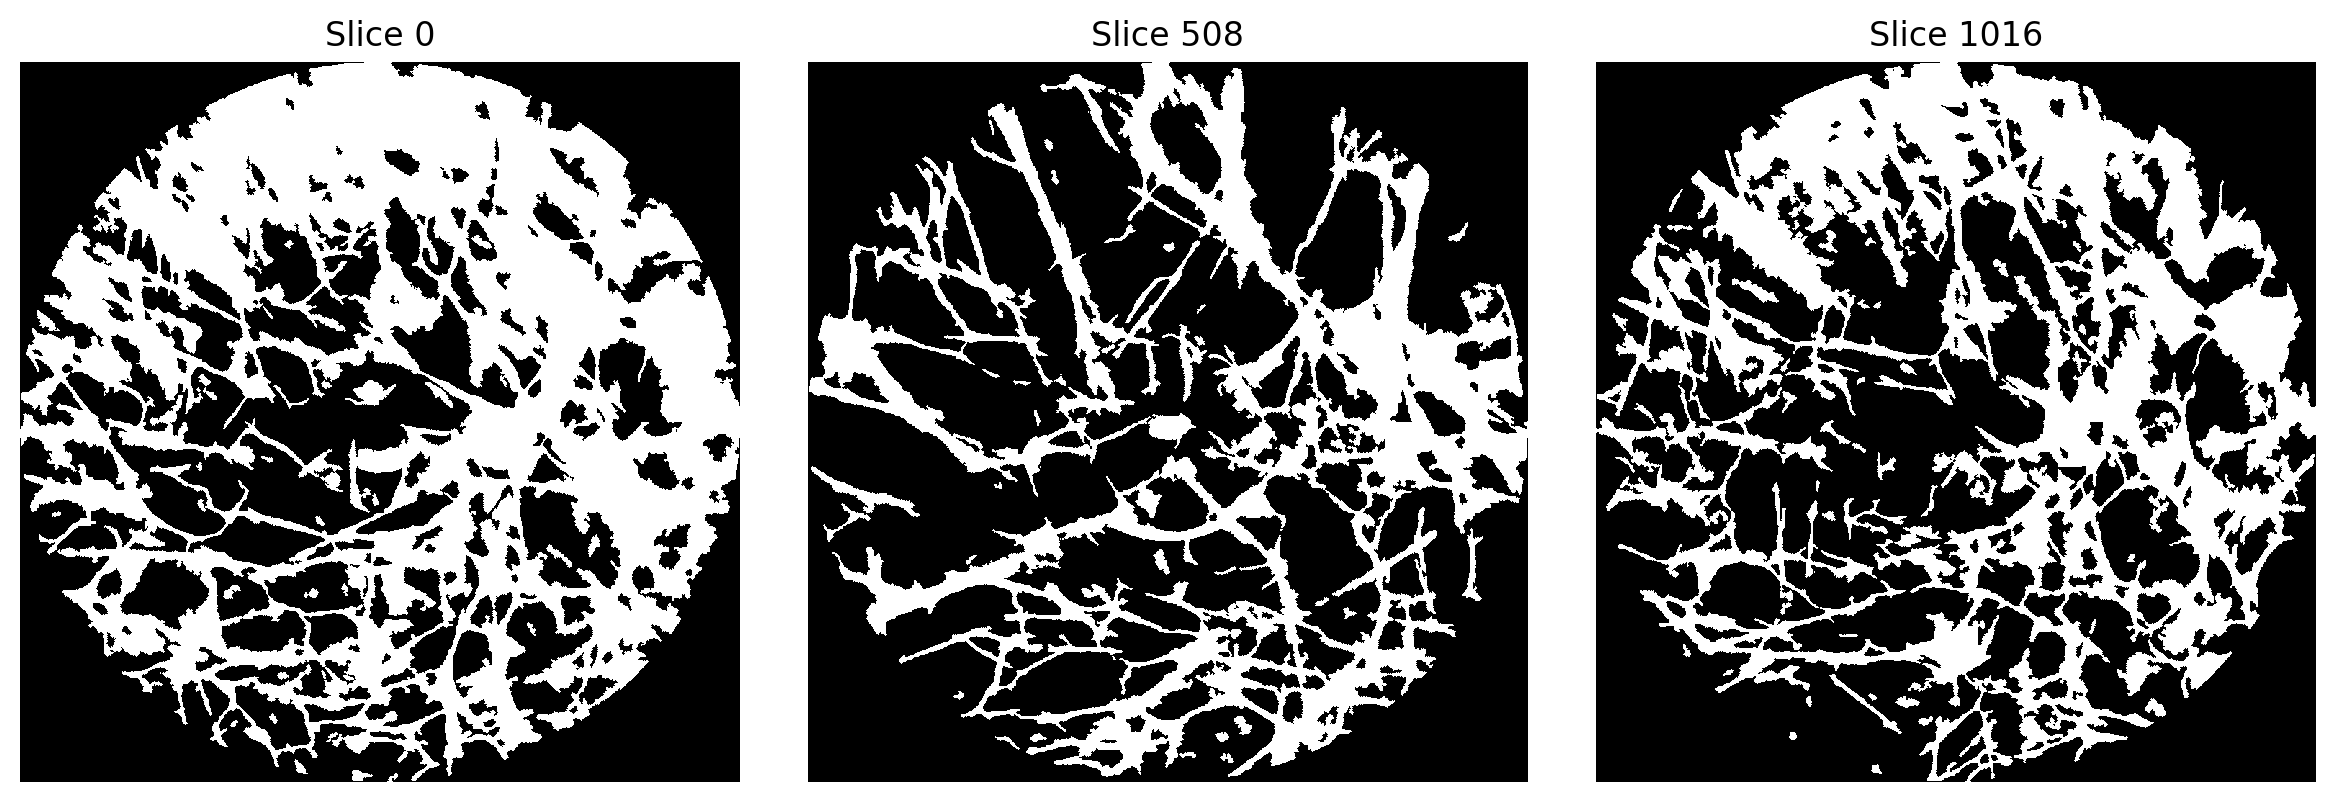

In [2]:
DATA_DIR = Path("/mnt/bgfs/projects/tomo_nano/yasmin/data/train_data_total_otsu/masks")  # <-- TODO: set this
PATTERN = "*.png"                        # e.g., '*.tif' or '*.png'
READ_AS_FLOAT = True                     # convert to float in [0, 1]

# Optional: restrict to a subset for quicker iteration (e.g., every 5th slice)
#STRIDE = 3      # use 1 for all slices
files = sorted(DATA_DIR.glob(PATTERN))
n = len(files)
N_SLICES = n

indices = np.linspace(0, n - 1, N_SLICES, dtype=int)
files = [files[i] for i in indices]
print(f"Found {len(files)} slices")

# ---- Load stack ----
if len(files) == 0:
    raise FileNotFoundError("No files found. Check DATA_DIR and PATTERN.")

stack = io.imread_collection([str(f) for f in files]).concatenate()
if READ_AS_FLOAT:
    stack = util.img_as_float(stack)

print("Stack shape:", stack.shape, "dtype:", stack.dtype)

# Quick peek
mid = stack.shape[0] // 2
fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[0].imshow(stack[0], cmap="gray"); axes[0].set_title(f"Slice {indices[0]}"); axes[0].axis("off")
axes[1].imshow(stack[mid], cmap="gray"); axes[1].set_title(f"Slice {indices[mid]}"); axes[1].axis("off")
axes[2].imshow(stack[-1], cmap="gray"); axes[2].set_title(f"Slice {indices[-1]}"); axes[2].axis("off")
plt.show()


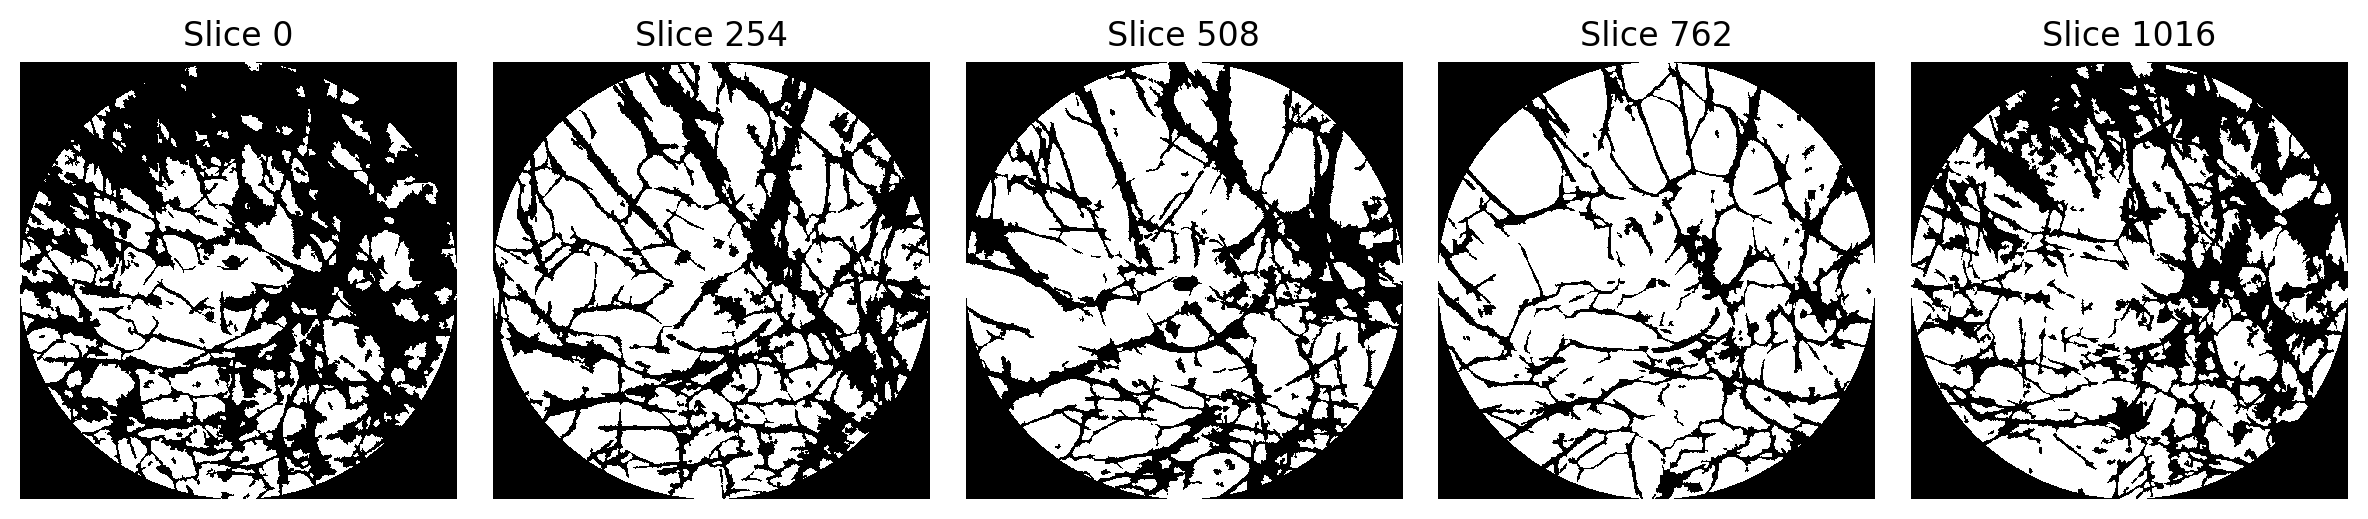

In [3]:
"""invertendo as cores pra pegar os poros e não as fibrilas"""

stack =  stack.astype(bool)
kcats = ~stack
kcats = tomopy.circ_mask(kcats, axis=0, ratio=1.0)

# Quick peek
mid = kcats.shape[0] // 2
quart = mid//2
fig, axes = plt.subplots(1,5, figsize=(12,4))
axes[0].imshow(kcats[0], cmap="gray"); axes[0].set_title(f"Slice {indices[0]}"); axes[0].axis("off")
axes[1].imshow(kcats[quart], cmap="gray"); axes[1].set_title(f"Slice {indices[quart]}"); axes[1].axis("off")
axes[2].imshow(kcats[mid], cmap="gray"); axes[2].set_title(f"Slice {indices[mid]}"); axes[2].axis("off")
axes[3].imshow(kcats[mid+quart], cmap="gray"); axes[3].set_title(f"Slice {indices[mid+quart]}"); axes[3].axis("off")
axes[4].imshow(kcats[-1], cmap="gray"); axes[4].set_title(f"Slice {indices[-1]}"); axes[4].axis("off")
plt.show()

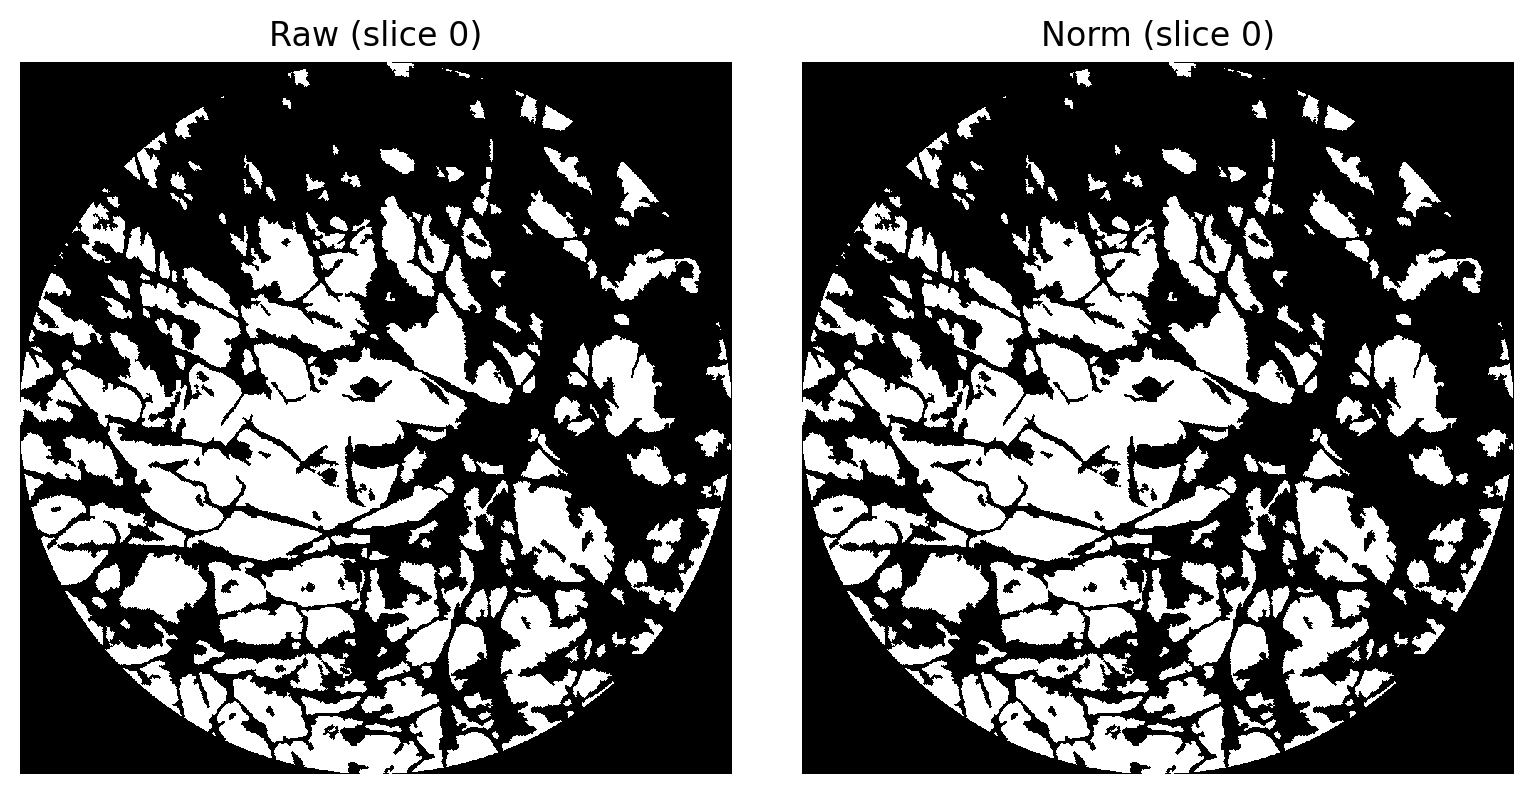

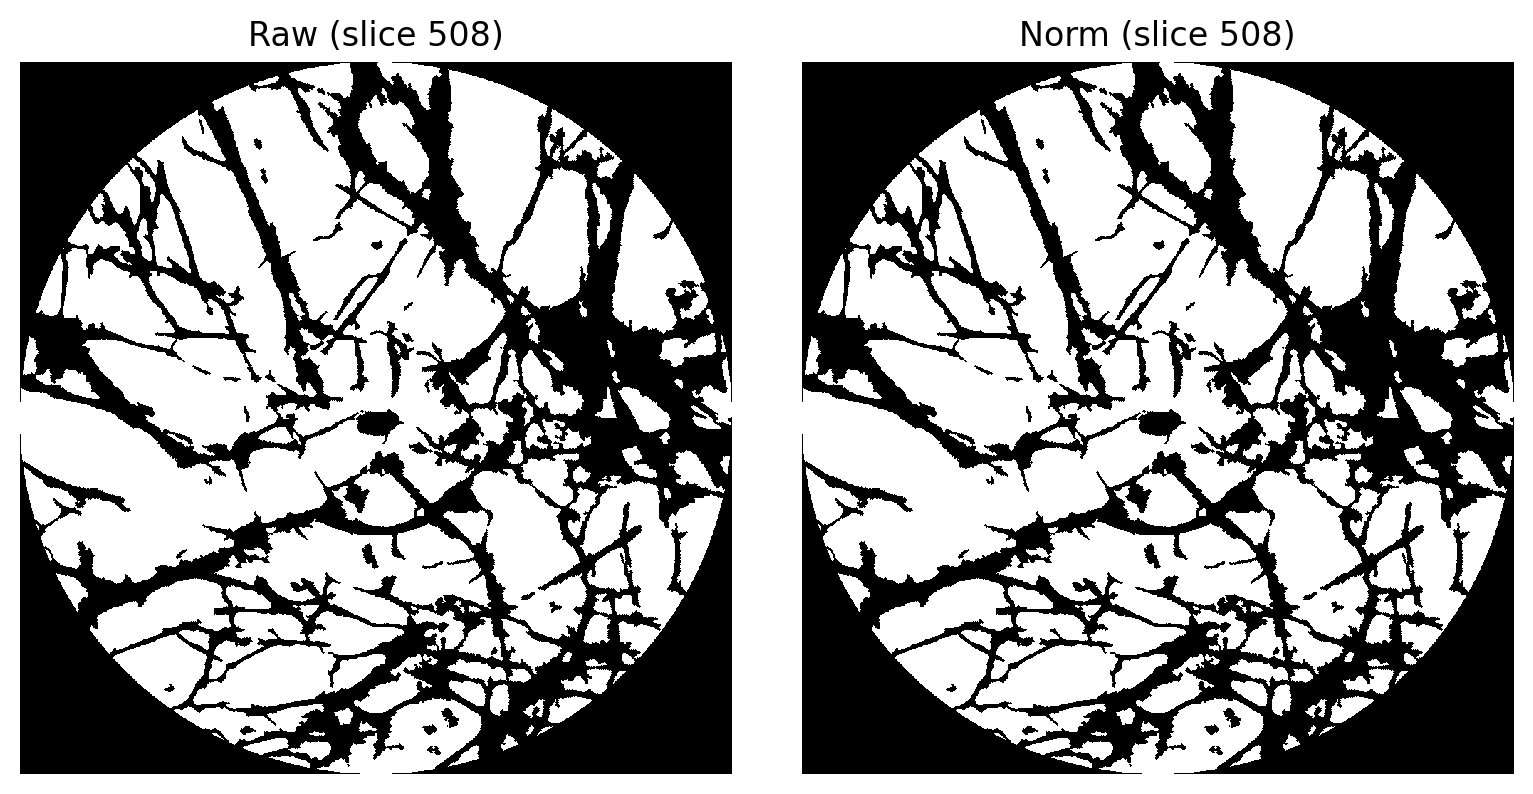

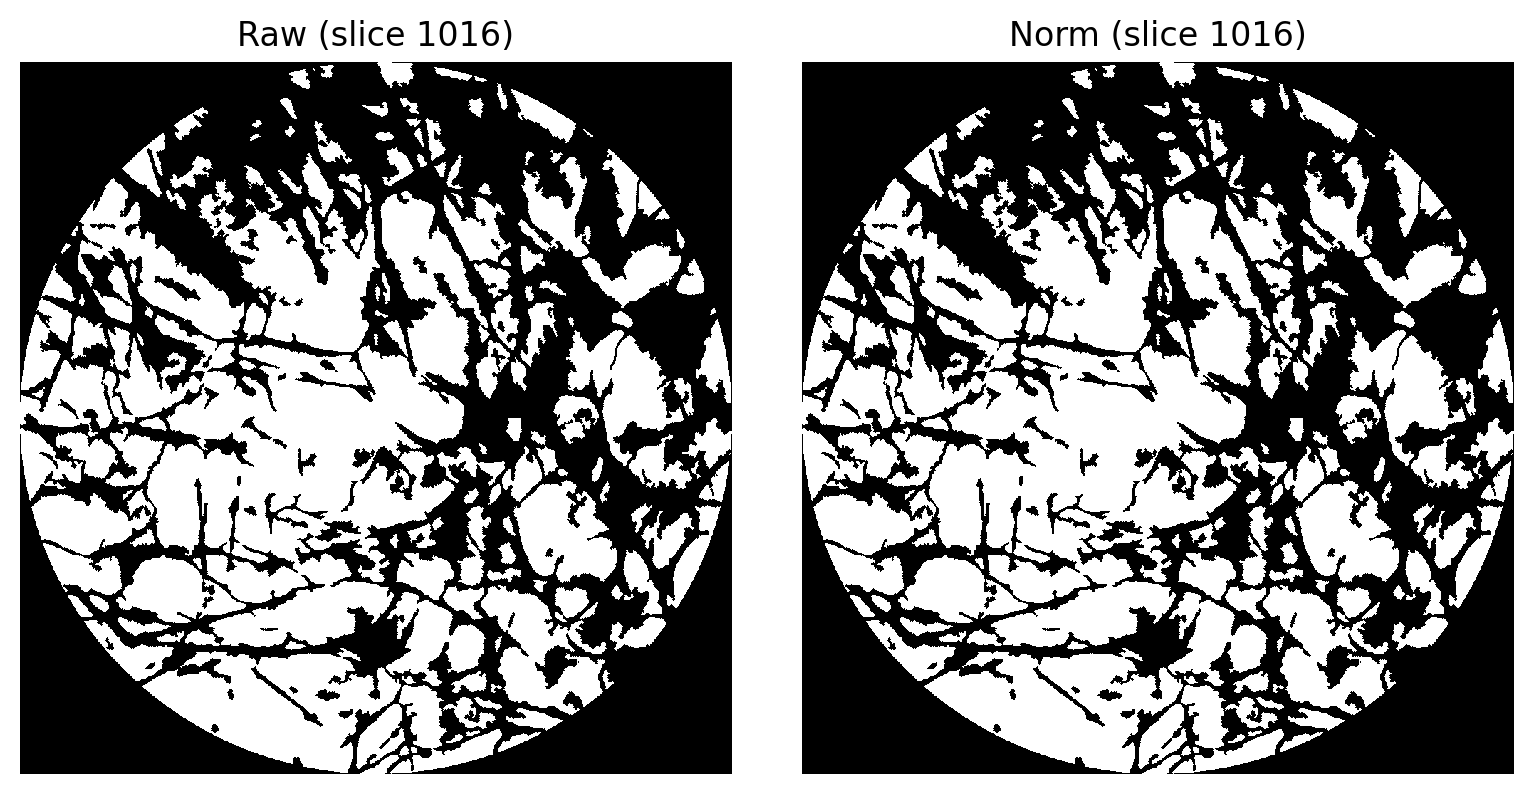

In [4]:
# Demo on a few slices
stack_inv =  kcats.astype(int)
ids = [0, stack_inv.shape[0]//2, stack_inv.shape[0]-1]
for sid in ids:
    img = stack_inv[sid]

    stack_min = stack_inv.min()
    stack_max = stack_inv.max()
    img_norm = (img - stack_min) / (stack_max - stack_min)
    
    fig, axes = plt.subplots(1,2, figsize=(8,4))
    axes[0].imshow(img, cmap="gray"); axes[0].set_title(f"Raw (slice {indices[sid]})"); axes[0].axis("off")
    axes[1].imshow(img_norm, cmap="gray"); axes[1].set_title(f"Norm (slice {indices[sid]})"); axes[1].axis("off")
    plt.show()

### CALCULANDO voxel_size

O voxel size (tamanho físico de cada voxel no volume reconstruído) é dado por:

voxel_size = pixel_size_no_detector/magnificação 

onde:

pixel → tamanho do pixel físico no detector (em metros, normalmente),

magn → fator de magnificação óptico/geométrico do sistema,

magn = 𝑧_1 + 𝑧_2 / z_1

sendo:

z1 → distância amostra → fonte,

z2 → distância amostra → detector.

Assim, o tamanho real do pixel na amostra (objeto) é:

pixel_obj = pixel / magn

E se o voxel for isotrópico (cubinho), então:

voxel_size = pixel_obj

**no notebook open_sirius o valor foi de 
1.3386313810053653e-06**

In [8]:
z_1 = 0.9298775 
z_2 = 0.07041549999999999 
pixel = 1.44 * 1e-9

magn = (z_1+z_2) / z_1 # fator de magnitude da projeção (ampliação)

pixel_obj = pixel / magn # tamanho do pixel na amostra (resolução real)

voxel_size = pixel_obj

print(voxel_size)

1.3386313810053651e-09


In [9]:
voxel_size = 1.34 # microns/voxel 
img1 = stack_inv.copy()

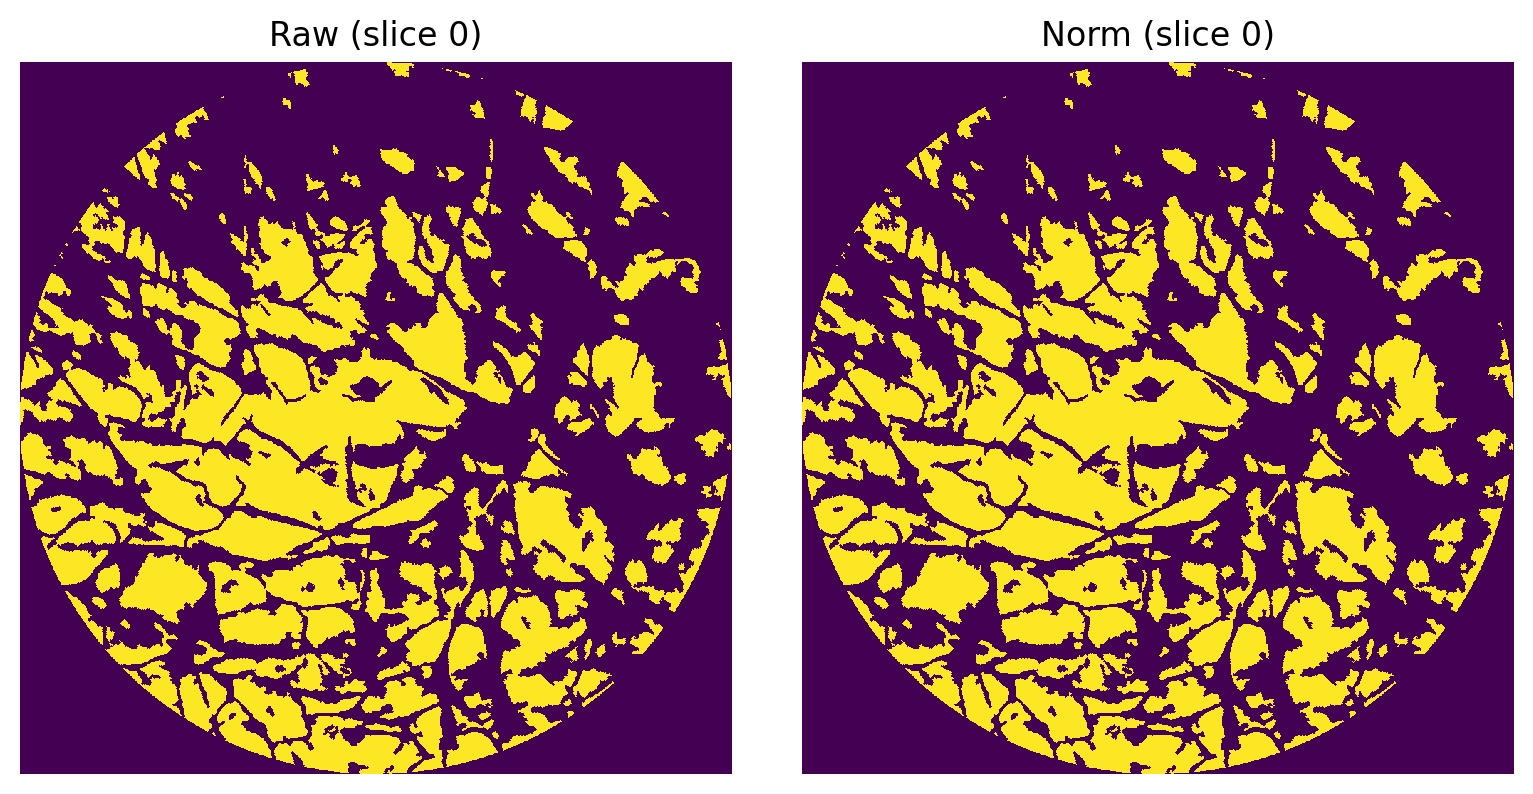

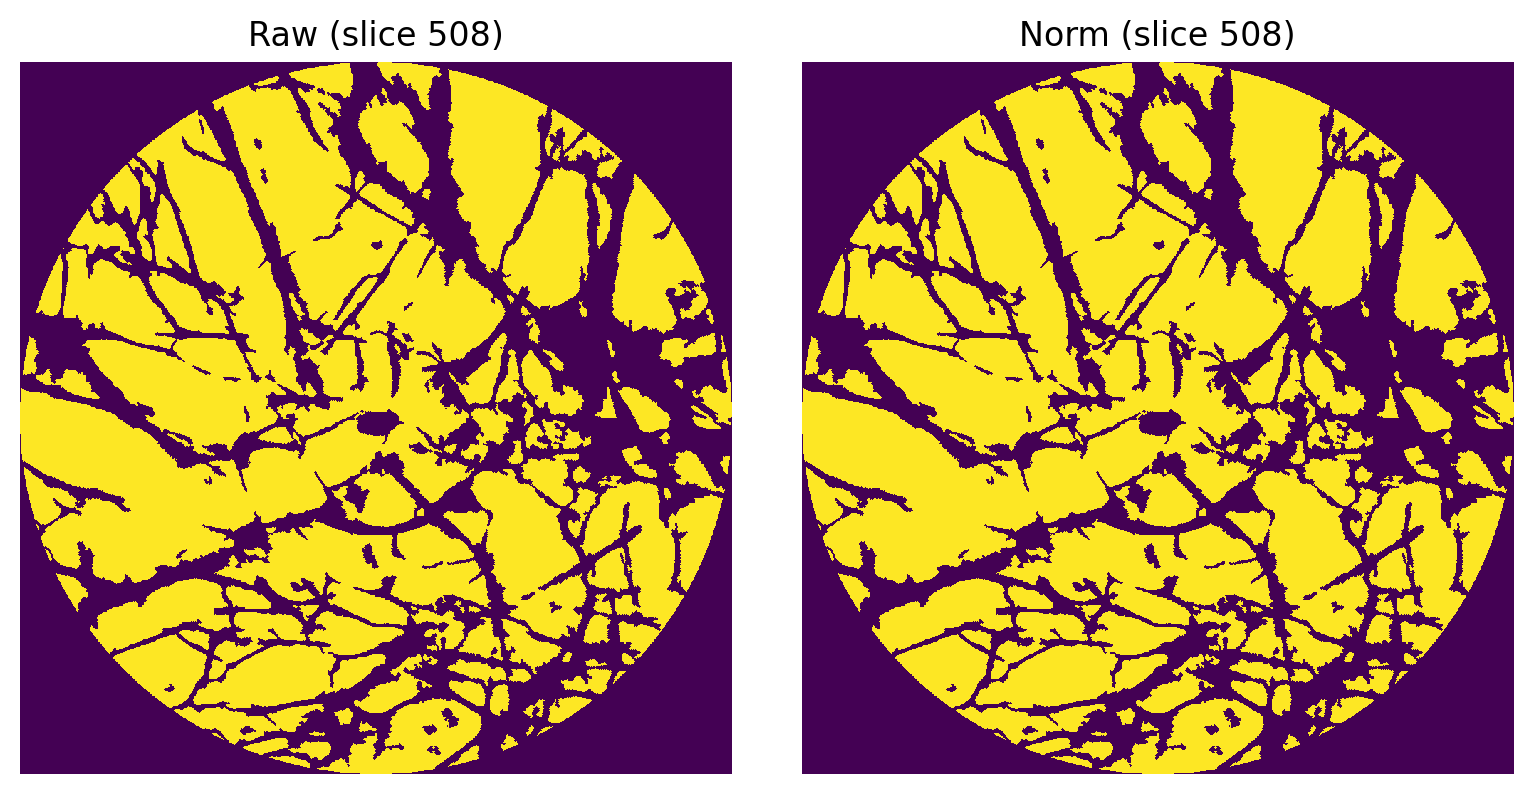

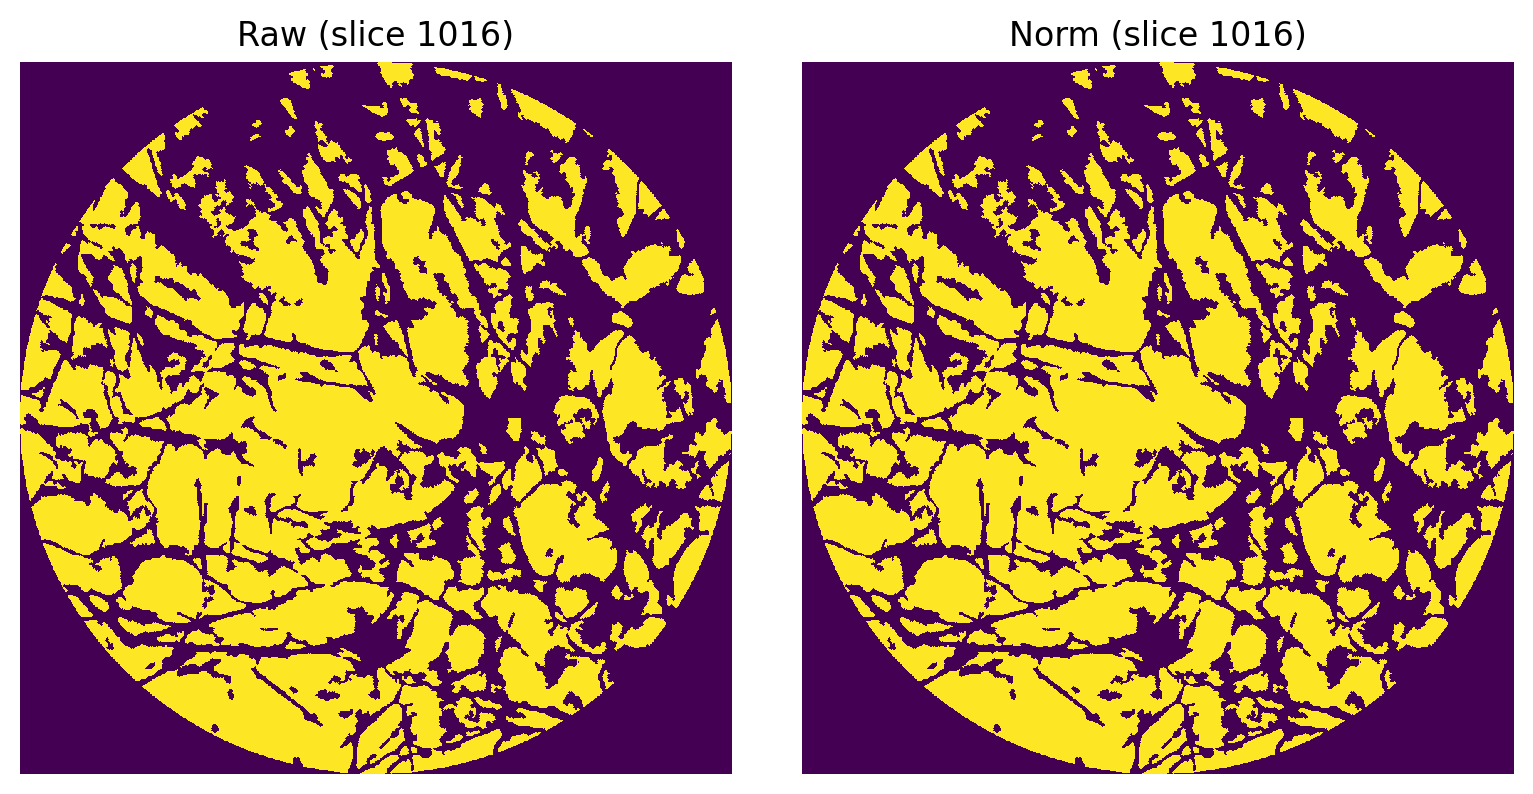

In [10]:
ids1 = [0, img1.shape[0]//2, img1.shape[0]-1]
for sid1 in ids1:
    img = img1[sid1]

    stack_min = img.min()
    stack_max = img.max()
    img_norm = (img - stack_min) / (stack_max - stack_min)
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img)#, cmap="gray")
    axes[0].set_title(f"Raw (slice {sid1})")
    axes[0].axis("off")
    
    axes[1].imshow(img_norm)#, cmap="gray")
    axes[1].set_title(f"Norm (slice {sid1})")
    axes[1].axis("off")
    
    plt.show()

In [11]:
x_profile = ps.metrics.porosity_profile(img1, axis=0)
y_profile = ps.metrics.porosity_profile(img1, axis=1)
z_profile = ps.metrics.porosity_profile(img1, axis=2)

In [12]:
positions_x = np.arange(len(x_profile)) * voxel_size
positions_y = np.arange(len(y_profile)) * voxel_size
positions_z = np.arange(len(z_profile)) * voxel_size

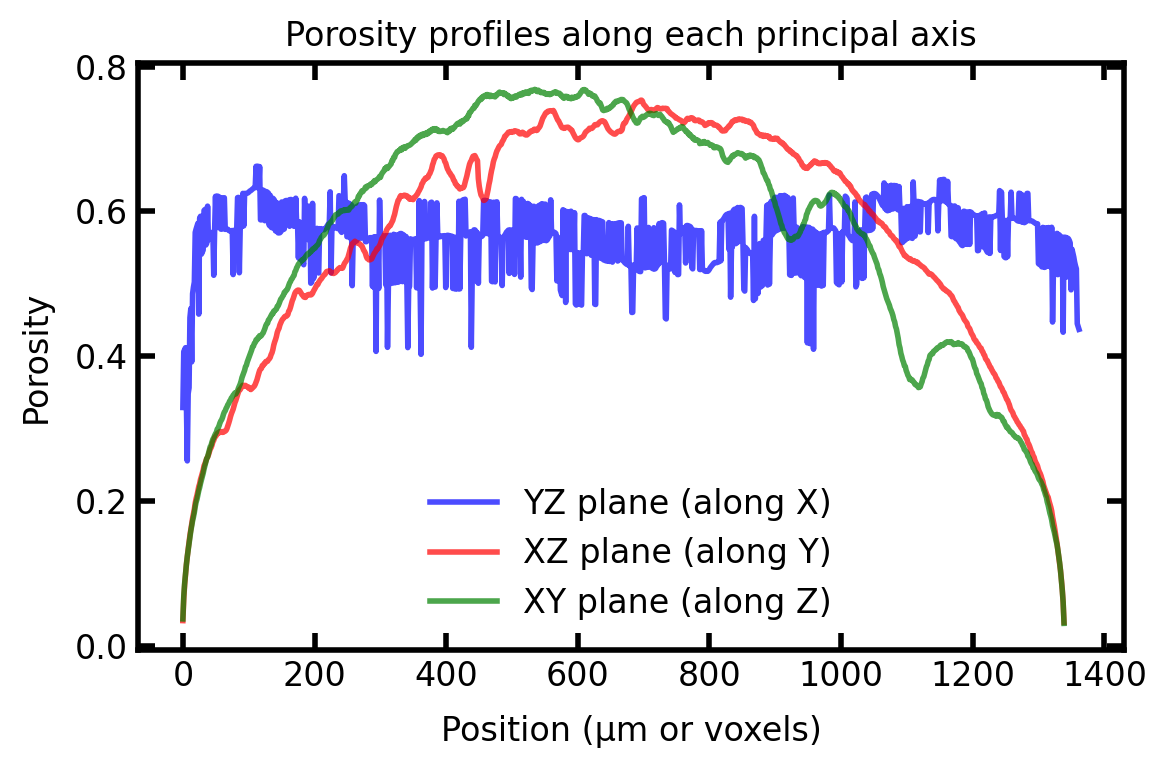

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(positions_x, x_profile, 'b-', label='YZ plane (along X)', alpha=0.7)
ax.plot(positions_y, y_profile, 'r-', label='XZ plane (along Y)', alpha=0.7)
ax.plot(positions_z, z_profile, 'g-', label='XY plane (along Z)', alpha=0.7)

ax.set_xlabel("Position (µm or voxels)")
ax.set_ylabel("Porosity")
ax.set_title("Porosity profiles along each principal axis")
ax.legend()
plt.show()

espessura de poros

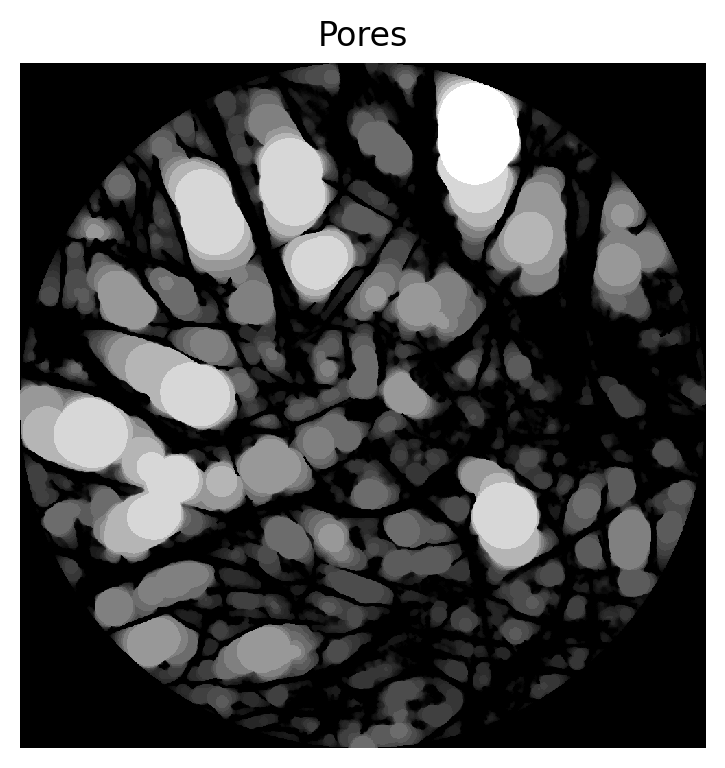

In [17]:
fig, ax = plt.subplots(1, figsize=[8, 4])

ax.imshow(thk[mid], interpolation='none', origin='lower', cmap="gray")
ax.axis(False)
ax.set_title('Pores')
plt.show()

In [ ]:
psd2 = ps.metrics.pore_size_distribution(im=thk)

fig, ax = plt.subplots(1, figsize=[4, 4])
ax.set_title("Pores")
ax.set_xlabel('log(Pore Radius) [voxels]')
ax.bar(x=psd2.LogR, height=psd2.pdf, width=psd2.bin_widths, edgecolor='k');

porespy faz esferas centradas em cada voxel até o sólido mais proximo, porém, faz isso de forma ordenada, não sobrepondo as eferas, assim aproxima a distribuição volumétrica real dos tamanhos de poros.

In [ ]:
import scipy.ndimage as spim

R = 8
strel = ps.tools.ps_ball(R)
img_temp1 = spim.binary_opening(img1, structure=strel)

fig, ax = plt.subplots(1, figsize=[8, 4])
ax.imshow(img_temp1[mid]*0.8, interpolation='none', origin='lower', cmap = "gray")
ax.axis(False)
ax.set_title('Pores')
plt.show()

we need to segment the image into discrete pores, which will become the regions that we analyze. For this purpose we’ll use the SNOW algorithm, which helps to find true local maximums in the distance transform that are used as markers in the watershed segementation.

In [ ]:
snow = ps.filters.snow_partitioning(im=img1)
regions = snow.regions*snow.im

0it [00:00, ?it/s]

In [ ]:
fig, ax = plt.subplots()
ax.imshow(regions, cmap=plt.cm.inferno);

In [ ]:
props = ps.metrics.regionprops_3D(regions)

In [ ]:
r = props[3]
attrs = [a for a in r.__dir__() if not a.startswith('_')]
print(attrs)

In [ ]:
df = ps.metrics.props_to_DataFrame(props)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].hist(df['volume'], edgecolor="k")
ax[1].hist(df['solidity'], edgecolor="k")
ax[2].hist(df['sphericity'], edgecolor="k")
ax[0].set_title("Volume")
ax[1].set_title("Solidity")
ax[2].set_title("Sphericity");

para olhar todas as propriedades de um poro de uma vez:

In [ ]:
df.iloc[0]

espessura local: